# load data

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

import pandas as pd
import numpy as np

In [62]:
# train_data
# 882808:117192
train_data = pd.read_csv("./train.csv",parse_dates=['auditing_date','due_date','repay_date']) #201801-20181231

# test_data
test_data = pd.read_csv("./test.csv",parse_dates=['auditing_date','due_date']) #20190201-20190331

# listing_info
listing_info = pd.read_csv("./listing_info.csv")

# user_info:数据插入时间不同而有重复
user_info = pd.read_csv("./user_info.csv",parse_dates = ['reg_mon','insertdate']) #20171231-20190330

# user_taglist:数据插入时间不同而有重复
user_taglist = pd.read_csv("./user_taglist.csv",parse_dates = ['insertdate']) #20171231-20190330

# # user_behavior
# user_behavior = pd.read_csv("./user_behavior.csv",parse_dates=['behavior_time']) # 20170705-20190330

# # user_repay
# user_repay = pd.read_csv("./user_repay.csv",parse_dates=['auditing_date','due_date','repay_date']) # 20170705-20200330

In [63]:
# user_repay[(user_repay['auditing_date']<="20190201")&(user_repay['auditing_date']>="20190101")&(user_repay['order_id']==1)]
# 62133
# 57222:4911

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20170705")&(user_repay['order_id']==1)] 
# 2665908
# 2493623:173985

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20180101")&(user_repay['order_id']==1)] 
# 1960867
# 1854069:113358

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20180101")&(user_repay['order_id']==1)]\
# .drop('order_id',axis=1).set_index(['user_id','listing_id']) \.loc[train_data.set_index(['user_id','listing_id']).index]

# user_repay:20190101-20190131 样本外验证
# user_repay:20180101-20181231 暂留
# user_repay:20170705-20171231 距离较远直接舍弃

# concat train_set

## concat listing_info

In [64]:
train_set = pd.merge(train_data,listing_info,how='left',on=['user_id','listing_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1000000, 14)
duplicated:
 False    1000000
dtype: int64


## concat user_info
合并后根据insertdate排序，然后根据['user_id','listing_id','auditing_date']去重保留最后一条最新信息

In [65]:
train_set = pd.merge(train_set,user_info,how='left',on=['user_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1034565, 26)
duplicated:
 False    1034565
dtype: int64


In [66]:
# 用户信息获取时间必须在成交日之前
# 注意：此步操作会将insertdate为NaT的记录排除掉而丢失样本
before_auditing_date = ((train_set['insertdate'].isnull()) |
                        (train_set['insertdate']<train_set['auditing_date']))
train_set = train_set[before_auditing_date] 
train_set.shape

(1000590, 26)

In [67]:
train_set = train_set.sort_values(by=['user_id','listing_id','insertdate'])
train_set = train_set.drop_duplicates(subset=['user_id','listing_id','auditing_date'],keep='last')
train_set.drop('insertdate',axis=1,inplace=True)
train_set.shape

(1000000, 25)

## concat user_taglist
合并后根据insertdate排序，然后根据['user_id','listing_id','auditing_date']去重保留最后一条最新信息

In [68]:
train_set = pd.merge(train_set,user_taglist,how='left',on=['user_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1182897, 37)
duplicated:
 False    1182897
dtype: int64


In [69]:
#用户标签信息获取时间必须在成交日之前
# 注意：此步操作会将insertdate为NaT的记录排除掉而丢失样本
before_auditing_date = ((train_set['insertdate'].isnull()) |
                        (train_set['insertdate']<train_set['auditing_date']))
train_set = train_set[before_auditing_date] 
train_set.shape

(1077835, 37)

In [70]:
train_set = train_set.sort_values(by=['user_id','listing_id','insertdate'])
# 有可能同一个人同一标的同一成交日，分多次还款，所以须加上'repay_date','repay_amt'进行去重，测试集不需要
train_set = train_set.drop_duplicates(subset=['user_id','listing_id','auditing_date','repay_date','repay_amt'],keep='last')
train_set.drop('insertdate',axis=1,inplace=True)
train_set.shape

(994095, 36)

## concat user_behavior

## data transform

### audit_reg_delta

In [71]:
train_set['audit_reg_delta'] = (train_set['auditing_date']-train_set['reg_mon']).dt.days #衡量用户新旧

### dummy

#### province

##### cell_province

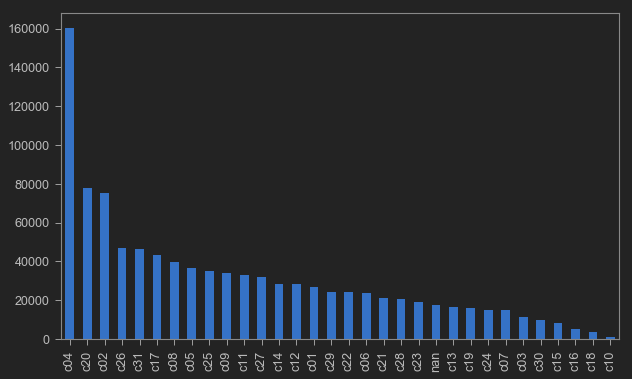

In [72]:
plt.figure(figsize=(10,6))
train_set['cell_province'].value_counts(dropna=False).plot(kind='bar')

In [73]:
train_set = pd.concat([train_set,
                       pd.get_dummies(train_set['cell_province'],prefix ='cell_province' ,dummy_na=True)],
                      axis=1)

##### id_province

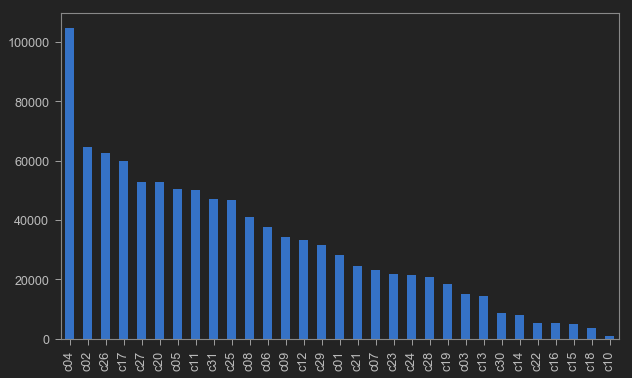

In [74]:
plt.figure(figsize=(10,6))
train_set['id_province'].value_counts(dropna=False).plot(kind='bar')

In [75]:
# train_set = pd.concat([train_set,
#                        pd.get_dummies(train_set['id_province'],prefix ='id_province' ,dummy_na=True)],
#                       axis=1)

In [76]:
# # c04
# # c02 c20 
# # c17 c08 c26 c31 c09 c25 c12 c05 c11 c27
# # c01 c21 c29 c06 c14 c28 c22 c13 c19 c23 c07 c24
# # c03  c30  c15  c16  c18  c10   
# # nan

# # train_set['cell_province'].value_counts(dropna=False)
# cond_1 = (train_set['cell_province'] =='c04')

# cond_2 = (train_set['cell_province'] =='c02')|(train_set['cell_province'] =='c20')

# cond_3 = ((train_set['cell_province'] =='c17')|(train_set['cell_province'] =='c08')|
#         (train_set['cell_province'] =='c26')|(train_set['cell_province'] =='c31')|
#         (train_set['cell_province'] =='c09')|(train_set['cell_province'] =='c25')|
#         (train_set['cell_province'] =='c12')|(train_set['cell_province'] =='c05')|
#         (train_set['cell_province'] =='c11')|(train_set['cell_province'] =='c27'))

# cond_4 = ((train_set['cell_province'] =='c01')|(train_set['cell_province'] =='c21')|
#          (train_set['cell_province'] =='c29')|(train_set['cell_province'] =='c06')|
#          (train_set['cell_province'] =='c14')|(train_set['cell_province'] =='c28')|
#          (train_set['cell_province'] =='c22')|(train_set['cell_province'] =='c13')|
#         (train_set['cell_province'] =='c19')|(train_set['cell_province'] =='c23')|
#         (train_set['cell_province'] =='c07')|(train_set['cell_province'] =='c24'))

# cond_5 = ((train_set['cell_province'] =='c03')|(train_set['cell_province'] =='c30')|
#          (train_set['cell_province'] =='c15')|(train_set['cell_province'] =='c16')|
#          (train_set['cell_province'] =='c18')|(train_set['cell_province'] =='c10'))

# # cond_6 = (train_set['cell_province'].isnull())

# train_set.loc[cond_1,'province_dummy'] = 1
# train_set.loc[cond_2,'province_dummy'] = 2
# train_set.loc[cond_3,'province_dummy'] = 3
# train_set.loc[cond_4,'province_dummy'] = 4
# train_set.loc[cond_5,'province_dummy'] = 5
# # train_set.loc[cond_6,'cell_province'] = 6

#### id_city[维度太高暂不处理]¶

#### age

In [77]:
train_set['age_dummy'] = pd.cut(train_set['age'],bins=[18,20,30,40,50,100],labels=[1,2,3,4,5])

In [78]:
train_set = pd.concat([train_set,
                       pd.get_dummies(train_set['age_dummy'],prefix ='age_dummy' ,dummy_na=True)],
                      axis=1)

### woe

In [107]:
train_set['y'] = (train_set['repay_amt'].isnull())*1

In [108]:
from woe import WOE

woe = WOE()

#### listing_cat

In [109]:
listing_cat_woe_map = woe.woe_single_x(train_set['listing_cat'].astype(str),train_set['y'])[0]
train_set['listing_cat'] = train_set['listing_cat'].astype(str).map(listing_cat_woe_map)

F:\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


#### id_city

In [110]:
train_set['id_city'].value_counts(dropna=False).tail()#.to_dict()

c19058    24
c10326    17
c26178    10
c25339     6
c04339     1
Name: id_city, dtype: int64

In [111]:
few_city_map = {#'c19058': 'c99999', 
                 'c25339':'c99999', 
                 'c04339':'c99999', 
                 'c26178':'c99999'}
train_set['id_city'] = train_set['id_city'].replace(few_city_map)

In [112]:
id_city_woe_map = woe.woe_single_x(train_set['id_city'].astype(str),train_set['y'])[0]
train_set['id_city'] = train_set['id_city'].astype(str).map(id_city_woe_map)

#### id_province

In [113]:
id_province_woe_map = woe.woe_single_x(train_set['id_province'].astype(str),train_set['y'])[0]
train_set['id_province'] = train_set['id_province'].astype(str).map(id_province_woe_map)

#### cell_province

In [114]:
cell_province_woe_map = woe.woe_single_x(train_set['cell_province'].astype(str),train_set['y'])[0]
train_set['cell_province'] = train_set['cell_province'].astype(str).map(cell_province_woe_map)

#### age_dummy

In [115]:
age_dummy_woe_map = woe.woe_single_x(train_set['age_dummy'].astype(str),train_set['y'])[0]
train_set['age_dummy'] = train_set['age_dummy'].astype(str).map(age_dummy_woe_map)

### correlation

In [28]:
corr = train_set.corr()
corr.loc[:,:] = np.tril(corr,k=-1)
corr = corr.stack()
pd.DataFrame(corr[corr.abs()>=0.80],columns=["corr"])
# train_set.corr()

corr
repay_amt          due_amt              1.000000
principal          due_amt              0.849301
                   repay_amt            0.848632
pvi                term                 0.999857
gender_male        gender_female       -1.000000
same_province_True same_province_False -1.000000
tag_1              have_tags            1.000000
audit_reg_delta    user_id             -0.895671
age_dummy_3.0      age_dummy            0.813337

In [29]:
# id_province_c01	cell_province_c01	0.814935
# id_province_c08	cell_province_c08	0.829896
# id_province_c09	cell_province_c09	0.852767
# id_province_c13	cell_province_c13	0.801062
# id_province_c19	cell_province_c19	0.802721
# id_province_c21	cell_province_c21	0.837004
# id_province_c28	cell_province_c28	0.806356
# id_province_c29	cell_province_c29	0.803051
# id_province_c30	cell_province_c30	0.805563
# id_province_c31	cell_province_c31	0.804709

In [30]:
train_set = train_set.drop(['term','gender_female','same_province_False','have_tags'],axis=1)

### missing rate

In [31]:
# tag_num               0.428059
# tag_1                 0.428059
# tag_2                 0.428059
# tag_3                 0.428059
# tag_4                 0.428059
# tag_5                 0.428059
# tag_6                 0.428059
# tag_7                 0.428059
# tag_8                0.428059
# tag_9                0.428059

In [32]:
train_set.apply(lambda x:x.isnull().sum()/len(x))

user_id               0.000000
listing_id            0.000000
auditing_date         0.000000
due_date              0.000000
due_amt               0.000000
repay_date            0.117483
repay_amt             0.117483
repay_date_delta      0.117483
auditing_days         0.000000
listing_cat           0.000000
rate                  0.000000
principal             0.000000
pvi                   0.000000
reg_mon               0.000000
age                   0.000000
cell_province         0.000000
id_province           0.000000
id_city               0.000000
gender_male           0.000000
gender_nan            0.000000
same_province_True    0.000000
same_province_nan     0.000000
tag_num               0.428059
tag_1                 0.428059
tag_2                 0.428059
tag_3                 0.428059
tag_4                 0.428059
tag_5                 0.428059
tag_6                 0.428059
tag_7                 0.428059
                        ...   
cell_province_c11     0.000000
cell_pro

In [116]:
train_set['tag_num'].fillna(0,inplace=True)
for i in range(1,10):
    train_set['tag_%s' % i].fillna(-1,inplace=True) # -1代表没有获得标签

In [34]:
# train_set.drop_duplicates().to_csv("./train_set_nobehavior.csv",index=False)

# concat test_set

## concat listing_info

In [79]:
test_set = pd.merge(test_data,listing_info,how='left',on=['user_id','listing_id'])
print(test_set.shape)
print("duplicated:\n",test_set.duplicated().value_counts())

(130000, 11)
duplicated:
 False    130000
dtype: int64


## concat user_info
合并后根据insertdate排序，然后根据['user_id','listing_id','auditing_date']去重保留最后一条最新信息

In [80]:
test_set = pd.merge(test_set,user_info,how='left',on=['user_id'])
print(test_set.shape)
print("duplicated:\n",test_set.duplicated().value_counts())

(155485, 23)
duplicated:
 False    155485
dtype: int64


In [81]:
# 用户信息获取时间必须在成交日之前
# 注意：此步操作会将insertdate为NaT的记录排除掉而丢失样本
before_auditing_date = ((test_set['insertdate'].isnull()) |
                        (test_set['insertdate']<test_set['auditing_date']))
test_set = test_set[before_auditing_date] 
test_set.shape

(155485, 23)

In [82]:
test_set = test_set.sort_values(by=['user_id','listing_id','insertdate'])
test_set = test_set.drop_duplicates(subset=['user_id','listing_id','auditing_date'],keep='last')
test_set.drop('insertdate',axis=1,inplace=True)
test_set.shape

(130000, 22)

## concat user_taglist
合并后根据insertdate排序，然后根据['user_id','listing_id','auditing_date']去重保留最后一条最新信息

In [83]:
test_set = pd.merge(test_set,user_taglist,how='left',on=['user_id'])
print(test_set.shape)
print("duplicated:\n",test_set.duplicated().value_counts())

(144858, 34)
duplicated:
 False    144858
dtype: int64


In [84]:
#用户标签信息获取时间必须在成交日之前
# 注意：此步操作会将insertdate为NaT的记录排除掉而丢失样本
before_auditing_date = ((test_set['insertdate'].isnull()) |
                        (test_set['insertdate']<test_set['auditing_date']))
test_set = test_set[before_auditing_date] 
test_set.shape

(144858, 34)

In [85]:
test_set = test_set.sort_values(by=['user_id','listing_id','insertdate'])
test_set = test_set.drop_duplicates(subset=['user_id','listing_id','auditing_date'],keep='last')
test_set.drop('insertdate',axis=1,inplace=True)
test_set.shape

(130000, 33)

## concat user_behavior

## data_transform

### audit_reg_delta

In [86]:
test_set['audit_reg_delta'] = (test_set['auditing_date']-test_set['reg_mon']).dt.days #衡量用户新旧

### dummy

#### province

##### cell_province

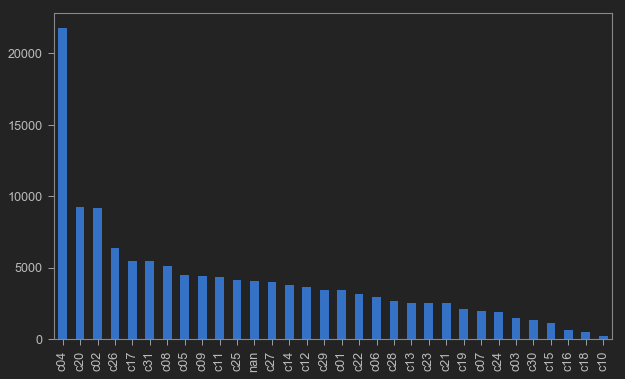

In [87]:
plt.figure(figsize=(10,6))
test_set['cell_province'].value_counts(dropna=False).plot(kind='bar')

In [88]:
test_set = pd.concat([test_set,
                       pd.get_dummies(test_set['cell_province'],prefix ='cell_province' ,dummy_na=True)],
                      axis=1)

##### id_province

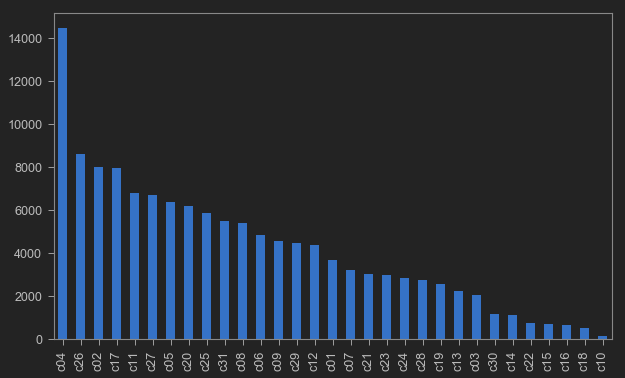

In [89]:
plt.figure(figsize=(10,6))
test_set['id_province'].value_counts(dropna=False).plot(kind='bar')

In [90]:
# test_set = pd.concat([test_set,
#                        pd.get_dummies(test_set['id_province'],prefix ='id_province' ,dummy_na=True)],
#                       axis=1)

#### id_city[维度太高暂不处理]

#### age

In [91]:
test_set['age_dummy'] = pd.cut(test_set['age'],bins=[18,20,30,40,50,100],labels=[1,2,3,4,5])

In [92]:
test_set = pd.concat([test_set,
                       pd.get_dummies(test_set['age_dummy'],prefix ='age_dummy' ,dummy_na=True)],
                      axis=1)

### woe

#### listing_cat

In [138]:
listing_cat_woe_map['53'] = (listing_cat_woe_map['52']+listing_cat_woe_map['51'])/2
listing_cat_woe_map['54'] = (listing_cat_woe_map['53']+listing_cat_woe_map['52']+listing_cat_woe_map['51'])/3

test_set['listing_cat'] = test_set['listing_cat'].astype(str).map(listing_cat_woe_map)

#### id_city

In [139]:
train_set['id_city'].value_counts(dropna=False).tail()#.to_dict()

-0.062955     27
-1.202389     26
 0.407049     24
 0.837832     17
-20.000000    17
Name: id_city, dtype: int64

In [140]:
test_set['id_city'].value_counts(dropna=False).tail()

c19058    5
c25113    3
c26178    2
c02339    1
c27339    1
Name: id_city, dtype: int64

In [141]:
test_set['id_city'] = test_set['id_city'].replace(few_city_map)

In [142]:
test_set['id_city'] = test_set['id_city'].astype(str).map(id_city_woe_map)

#### id_province

In [143]:
test_set['id_province'] = test_set['id_province'].astype(str).map(id_province_woe_map)

#### cell_province

In [144]:
test_set['cell_province'] = test_set['cell_province'].astype(str).map(cell_province_woe_map)

#### age_dummy

In [145]:
test_age_dummy_woe_map = {'1': -0.21276862727554233,
 '2': -0.18214160046836594,
 '3': -0.16250553887944788,
 '4': -0.19367804136771047,
 '5': -0.163618420877076,
 'nan': -0.20671310333980789}
test_set['age_dummy'] = test_set['age_dummy'].astype(str).map(test_age_dummy_woe_map)

### correlation

In [146]:
corr = test_set.corr()
corr.loc[:,:] = np.tril(corr,k=-1)
corr = corr.stack()
pd.DataFrame(corr[corr.abs()>=0.8],columns=["corr"])
# train_set.corr()

,,corr
principal,due_amt,0.873441
pvi,term,0.999930
gender_male,gender_female,-1.000000
same_province_True,same_province_False,-1.000000
tag_1,have_tags,1.000000
audit_reg_delta,user_id,-0.966199
age_dummy_3.0,age_dummy,0.845353


In [147]:
test_set = test_set.drop(['term','gender_female','same_province_False','have_tags'],axis=1)

### missing rate

In [148]:
test_set.apply(lambda x:x.isnull().sum()/len(x))[['listing_cat','age_dummy']]

listing_cat    0.0
age_dummy      0.0
dtype: float64

In [149]:
test_set['tag_num'].fillna(0,inplace=True)
for i in range(1,10):
    test_set['tag_%s' % i].fillna(-1,inplace=True) # -1代表没有获得标签

In [150]:
test_set.drop_duplicates().to_csv("./test_set_nobehavior.csv",index=False)